# Exploratory analyses

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import psycopg2
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Pull data from postgreSQL db
**TO DO**: Once weather data properly scraped & stored in db, pull BART & weather together as a join into a dataframe. 

In [7]:
# open db connection
dbname = 'bart_db'
username = 'bkhurley'
con = None
con = psycopg2.connect(database=dbname, user=username)

# query the data & store in a dataframe
sql_query = """
SELECT * FROM bart_entry_exit;
"""
entry_exit_df = pd.read_sql_query(sql_query,con, index_col='id')
con.close() #close dn connection

In [10]:
entry_exit_df.head()

,date,hour,direction,station,entries,exits,day,month
id,,,,,,,,
0,2011-01-01,0,northbound,12TH,16,102,Saturday,1
1,2011-01-01,0,northbound,16TH,168,26,Saturday,1
2,2011-01-01,0,northbound,19TH,19,91,Saturday,1
3,2011-01-01,0,northbound,24TH,72,32,Saturday,1
4,2011-01-01,0,northbound,BALB,72,5,Saturday,1


In [16]:
entry_exit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127992 entries, 0 to 2127991
Data columns (total 8 columns):
date         object
hour         int64
direction    object
station      object
entries      int64
exits        int64
day          object
month        int64
dtypes: int64(4), object(4)
memory usage: 146.1+ MB


In [15]:
entry_exit_df['entries'].describe()

count    2.127992e+06
mean     1.710690e+02
std      3.091400e+02
min      1.000000e+00
25%      1.600000e+01
50%      6.100000e+01
75%      1.940000e+02
max      4.412000e+03
Name: entries, dtype: float64

## Check out the distribution

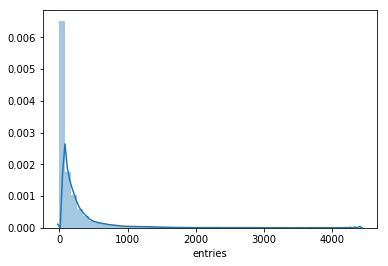

In [11]:
sns.distplot(entry_exit_df['entries'])

In [145]:
#rowdicts = [] 
#for l, d in bart_entry_df.groupby("hour station direction".split()):
#    d = {"hour": l[0], "station": l[1], "direction": l[2]}
#    rowdicts.append(d)                               
#
#df2 = pd.DataFrame.from_dict(rowdicts)
grouped_df = bart_entry_df.groupby(['hour', 'station', 'direction']).mean()
grouped_df.reset_index(inplace=True)
grouped_df.drop(labels='month', axis=1, inplace=True)

In [146]:
grouped_df.head()

,hour,station,direction,entries
0,0,12TH,northbound,8.675000
1,0,12TH,southbound,21.572271
2,0,16TH,northbound,89.052486
3,0,16TH,southbound,47.867403
4,0,19TH,northbound,13.262570


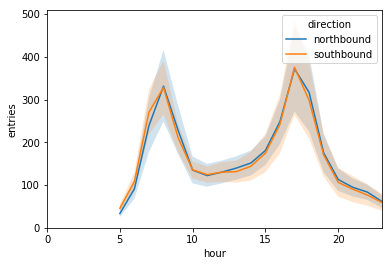

In [147]:
sns.tsplot(data=grouped_df, time="hour", unit='station', value="entries", condition="direction")

In [153]:
# filter for the Mcarthur station
df_mcar = bart_entry_df.loc[bart_entry_df['station']=='MCAR', :]

# avg by station by hour, day, month
mcar_mean = df_mcar.groupby(by=['station', 'day', 'hour']).mean()['entries']
mcar_mean.fillna(value=0, inplace=True)

mcar_mean.head(100)

station  day       hour
MCAR     Friday    0        14.480000
                   1         2.500000
                   4        10.291667
                   5        29.232323
                   6        88.019231
                   7       254.759615
                   8       389.990385
                   9       304.333333
                   10      169.872549
                   11      125.303922
                   12      116.303922
                   13      107.852941
                   14      105.931373
                   15      115.862745
                   16      154.647059
                   17      224.656863
                   18      191.372549
                   19      134.784314
                   20       81.686275
                   21       63.911765
                   22       54.382353
                   23       41.372549
         Monday    0        11.434343
                   1         2.000000
                   4        12.000000
                   5      

Do some pivots to get a glimpse of temporal trends

In [150]:
day_hour_avg = df_mcar.groupby(by=['day', 'hour']).mean()['entries'].unstack()
day_hour_avg.fillna(value=0, inplace=True)
day_hour_avg.head(10)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Friday,14.480000,2.50,0.0,0.0,10.291667,29.232323,88.019231,254.759615,389.990385,304.333333,...,105.931373,115.862745,154.647059,224.656863,191.372549,134.784314,81.686275,63.911765,54.382353,41.372549
Monday,11.434343,2.00,0.0,0.0,12.000000,29.923077,88.505155,269.122449,397.009615,293.951923,...,90.721154,96.990385,133.644231,202.009615,175.423077,92.615385,52.509615,41.990385,35.153846,22.990385
Saturday,27.019608,20.75,35.0,17.5,0.000000,0.000000,15.750000,38.272727,59.480392,87.803922,...,119.500000,102.539216,98.803922,102.480392,90.441176,91.480392,73.029412,59.980392,53.519608,40.480392
Sunday,26.147059,1.00,0.0,0.0,0.000000,0.000000,220.000000,149.500000,33.098039,58.186275,...,95.147059,78.823529,67.343137,65.392157,61.578431,51.823529,42.480392,39.225490,32.960784,22.921569
Thursday,13.845361,0.00,0.0,0.0,13.240000,32.039216,99.960784,295.029412,439.615385,333.730769,...,99.028846,105.740385,146.086538,238.432692,206.173077,113.250000,66.865385,53.336538,46.471154,28.480769
Tuesday,11.294737,0.00,0.0,0.0,12.666667,31.165049,99.625000,299.576923,455.355769,337.067308,...,92.942308,100.826923,146.894231,230.528846,204.567308,105.894231,58.278846,49.980769,41.673077,25.711538
Wednesday,13.473684,4.00,0.0,0.0,12.387755,31.990291,98.250000,294.807692,470.211538,334.346154,...,97.423077,104.884615,148.586538,235.125000,203.326923,109.384615,60.451923,51.538462,43.576923,27.961538


Text(0.5,1,'Avg # entries at MacArthur station')

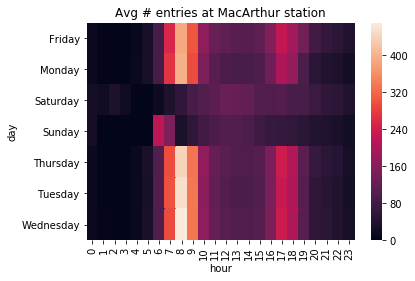

In [151]:
# plot heat map of the days and hours with most rides
sns.heatmap(day_hour_avg)
plt.title('Avg # entries at MacArthur station')

Might want to investigate the 6am blip on Sunday. Seems like a weird time to have a ridership spike.